In [1]:
# Initialization
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.utils.class_weight import compute_class_weight

from keras.models import Model, load_model
from keras.utils import to_categorical # one-hot-encoding

# Required for loss function
import math
from tensorflow.python.keras import losses

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Set someparameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# Original size = 572*572
LABEL_CLASS = 3

MODEL_NAME = 'model-lab-Ls-unet-epoch100.h5'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
# Define pre-process function

from skimage.transform import resize

def pre_process(img, img_height, img_width, norm = False, rescale = False, mask = False):
    img = np.array(img)                 #list to array
    proc_img = []
    
    #proc_img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        
    if mask:
        proc_img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    else:
        proc_img = img[:,:,np.newaxis]
        proc_img = resize(img, (img_height, img_width, 1), mode='constant', preserve_range=True)
        
    if rescale:
        proc_img /= 255
        
    #image normalization
    if norm:
        #adjusted_std = max(np.std(proc_img), 1.0/np.sqrt(proc_img.size))
        ipsilon = 0.0001
        proc_img = (proc_img-np.mean(proc_img))/np.std(proc_img)+ipsilon
        
    return proc_img

In [5]:
# Importing data...

# Path for Linux
#TRAIN_PATH = '/home/ziheng/UNet/dataset_lab/train/'
#TEST_PATH = '/home/ziheng/UNet/dataset_lab/test/'

# Path for Windows
TRAIN_PATH = 'F:\\MA\\data\\NIH\\Ls\\20180717_161620(new_Ls)\\train\\'
TEST_PATH = 'F:\\MA\\data\\NIH\\Ls\\20180717_161620(new_Ls)\\test\\'


# original lab dataset
# 'F:\\MA\\data\\dataset_lab\\train\\'
# L-shape dataset
# 'F:\\MA\\data\\NIH\\Ls\\20180717_161620(new_Ls)\\train\\'
# DISCO dataset
# 'F:\\MA\\data\\Swain_lab\\train\\'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH + 'in/'))[2]
test_ids = next(os.walk(TEST_PATH + 'in/'))[2]

# X_test: original images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
# Y_test: masks
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)
# Y_orig: original mask without one-hot encoding
#Y_orig = np.zeros((len(test_ids), 64, 64), dtype=np.uint8)
    
    
# Get and resize test images
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    img = imread(TEST_PATH + 'in/' + id_)
    X_test[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, norm = False, rescale = True)
    
    mask = imread(TEST_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    #Y_orig[n] = mask
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    # Resizing need to be done AFTER one-hot encoding!!!!!!!
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_test[n] = mask
    
    
print('Done!')

Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 17.93it/s]


Done!


In [6]:
Y_orig.shape

(11, 64, 64)

In [7]:
def IoU(y_true,y_pred):
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = intersection / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))
    return score

def IoU_loss(y_true , y_pred):
    loss = 1 - IoU(y_true, y_pred)
    return loss

In [8]:
# Define custom metrics and loss functions
def dice_coeff(y_true,y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true , y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss (y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
    return loss

# The same as log_loss
def mlogloss(target, pred):
    score = 0.0
    for i in range(len(pred)):
        pp = pred[i]
        for j in range(len(pp)):
            prob = pp[j]
            if prob < 1e-15:
                prob = 1e-15
            score += target[i][j] * math.log(prob)
    return -score/len(pred)

In [9]:
# Predict on train, val and test
model = load_model('.\\model\\' + MODEL_NAME, custom_objects={'bce_dice_loss': bce_dice_loss, 'IoU': IoU, 'dice_loss': dice_loss})
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
#for i in range(len(preds_test)):
#    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                       (sizes_test[i][0], sizes_test[i][1]), 
#                                       mode='constant', preserve_range=True))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
11/11 [==============================] - 1s 81ms/step


In [10]:
# Generate the mask wihtout one-hot-encoding 
preds_test_mask = np.zeros(shape=(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2]))

for i in range(preds_test_t.shape[0]):
    for y in range(preds_test_t.shape[1]):
        for x in range(preds_test_t.shape[2]):
            if preds_test_t[i, y, x, 1] == 1:
                preds_test_mask[i, y, x] = 1
            elif preds_test_t[i, y, x, 2] == 1:
                preds_test_mask[i, y, x] = 2
            else:
                preds_test_mask[i, y, x] = 0

1


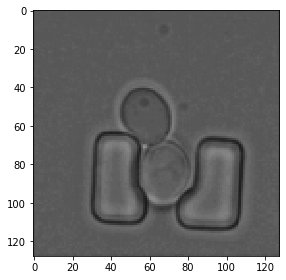

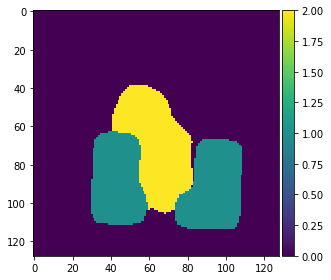

In [33]:
# Visualize the test image + the prediction masks
#ix = random.randint(0, len(test_ids)-1)
ix = 1
print(ix)

plt.figure()
#plt.grid(None)
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

#plt.grid(None)
#imshow(Y_orig[ix])
#plt.show()

plt.figure()
#plt.grid(None)
imshow(np.squeeze(preds_test_mask[ix]))
plt.show()

In [44]:
################### Don't run unless you want to generate images!!!!!!! ######################
##############################################################################################
# Generate and save the test image + the prediction masks
#ix = random.randint(0, len(test_ids))
ix = 11
print(ix)

plt.figure()
#plt.grid(None)
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
#plt.show()
plt.savefig('test_img_' + str(ix) + '.png')

#plt.grid(None)
#plt.figure()
#imshow(np.squeeze(Y_test[ix,:,:,mask_category])) 
#plt.show()

plt.figure()
#plt.grid(None)
imshow(np.squeeze(preds_test_mask[ix]))
#plt.show()
plt.savefig('preds_mask_' + str(ix) + '.png')

11


IndexError: index 11 is out of bounds for axis 0 with size 11

<Figure size 432x288 with 0 Axes>

In [12]:
# Define evaluation metrics
def metric_IoU(target, prediction):
    ipsilon = 0.0001
    
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    return (np.sum(intersection)+ipsilon)/(np.sum(union)+ipsilon) 

def metric_precision(target, prediction):
    ipsilon = 0.0001
    
    target_bool = np.array(target, dtype = 'bool')
    prediction_bool = np.array(prediction, dtype = 'bool')
    TP = np.logical_and(target_bool, prediction_bool)
    FP = np.logical_and(~target_bool, prediction_bool)
    return (np.sum(TP)+ipsilon)/(np.sum(TP)+np.sum(FP)+ipsilon)
    
def metric_recall(target, prediction):
    ipsilon = 0.0001
    
    target_bool = np.array(target, dtype = 'bool')
    prediction_bool = np.array(prediction, dtype = 'bool')
    TP = np.logical_and(target_bool, prediction_bool)
    FN = np.logical_and(target_bool, ~prediction_bool)
    return (np.sum(TP)+ipsilon)/((np.sum(TP)+np.sum(FN))+ipsilon)
    
def metric_f1(target, prediction):
    precision = metric_precision(target, prediction)
    recall = metric_recall(target, prediction)
    return 2*precision*recall/(precision+recall)

In [13]:
IoU_score = []
class_IoU_score = []
class_f1_score = []
class_precision_score = []
class_recall_score =  []

for d in range(Y_test.shape[3]):
    class_IoU_score.append([])
    class_f1_score.append([])
    class_precision_score.append([])
    class_recall_score.append([])

for i in range(len(X_test)):
    IoU_score.append(metric_IoU(Y_test[i], preds_test_t[i]))
    for d in range(Y_test.shape[3]):
        class_IoU_score[d].append(metric_IoU(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_f1_score[d].append(metric_f1(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_precision_score[d].append(metric_precision(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_recall_score[d].append(metric_recall(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        
IoU_score = np.array(IoU_score)
class_IoU_score = np.array(class_IoU_score)
class_f1_score = np.array(class_f1_score)
class_precision_score = np.array(class_precision_score)
class_recall_score = np.array(class_recall_score)

IoU_result = pd.DataFrame(data = class_IoU_score.transpose(), columns = ['Background', 'Trap', 'Cell'])
f1_result = pd.DataFrame(data = class_f1_score.transpose(), columns = ['Background', 'Trap', 'Cell'])
precision_result = pd.DataFrame(data = class_precision_score.transpose(), columns = ['Background', 'Trap', 'Cell'])
recall_result = pd.DataFrame(data = class_recall_score.transpose(), columns = ['Background', 'Trap', 'Cell'])

In [47]:
IoU_result.describe().round(4)

,Background,Trap,Cell
count,52.0000,52.0000,52.0000
mean,0.8739,0.8841,0.8510
std,0.0143,0.0212,0.0499
min,0.8372,0.8459,0.6668
25%,0.8645,0.8706,0.8313
50%,0.8743,0.8831,0.8613
75%,0.8867,0.8969,0.8875
max,0.8957,0.9316,0.9110


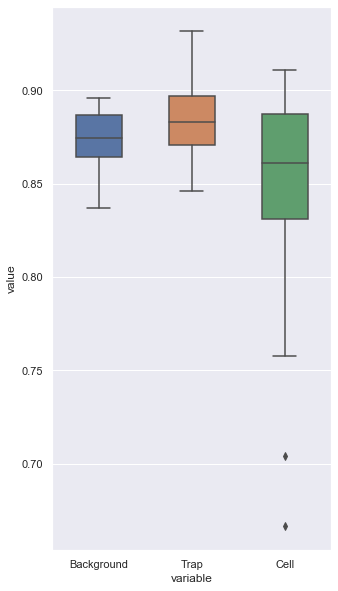

In [57]:
sns.set(rc={'figure.figsize':(5, 10)})
sns.boxplot(x="variable", y="value", data=pd.melt(IoU_result), width = 0.5)
#sns.boxplot(IoU_result)

#plt.show()
plt.savefig('IoU.png')

In [58]:
f1_result.describe().round(4)

,Background,Trap,Cell
count,52.0000,52.0000,52.0000
mean,0.9327,0.9383,0.9187
std,0.0082,0.0119,0.0306
min,0.9114,0.9165,0.8001
25%,0.9273,0.9308,0.9079
50%,0.9329,0.9379,0.9255
75%,0.9400,0.9456,0.9404
max,0.9450,0.9646,0.9534


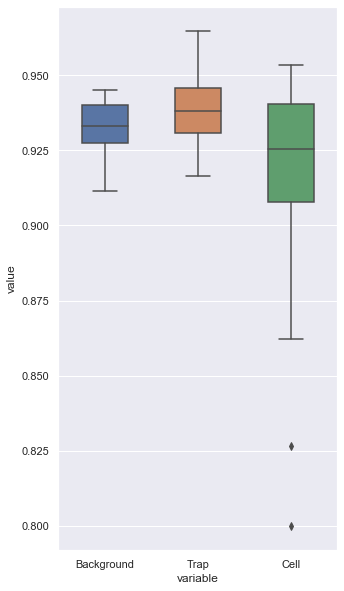

In [59]:
sns.set(rc={'figure.figsize':(5, 10)})
sns.boxplot(x="variable", y="value", data=pd.melt(f1_result), width = 0.5)
#sns.boxplot(IoU_result)

#plt.show()
plt.savefig('f1.png')

In [60]:
precision_result.describe().round(4)

,Background,Trap,Cell
count,52.0000,52.0000,52.0000
mean,0.8797,0.9122,0.9139
std,0.0118,0.0378,0.0479
min,0.8491,0.8534,0.7155
25%,0.8715,0.8786,0.8932
50%,0.8795,0.9082,0.9166
75%,0.8904,0.9474,0.9467
max,0.8982,0.9764,0.9891


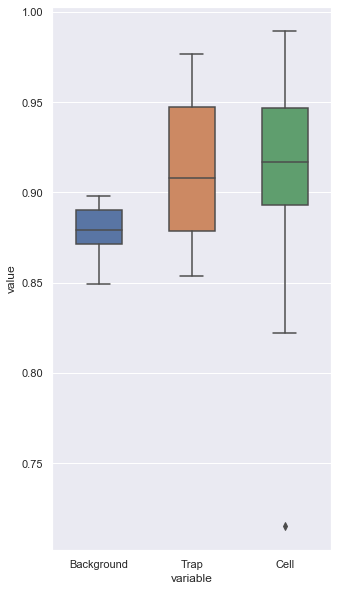

In [61]:
sns.set(rc={'figure.figsize':(5, 10)})
sns.boxplot(x="variable", y="value", data=pd.melt(precision_result), width = 0.5)

#plt.show()
plt.savefig('precision.png')

In [62]:
recall_result.describe().round(4)

,Background,Trap,Cell
count,52.0000,52.0000,52.0000
mean,0.9924,0.9682,0.9276
std,0.0050,0.0279,0.0541
min,0.9784,0.8895,0.7406
25%,0.9900,0.9503,0.9129
50%,0.9928,0.9789,0.9464
75%,0.9958,0.9914,0.9639
max,0.9997,0.9995,0.9888


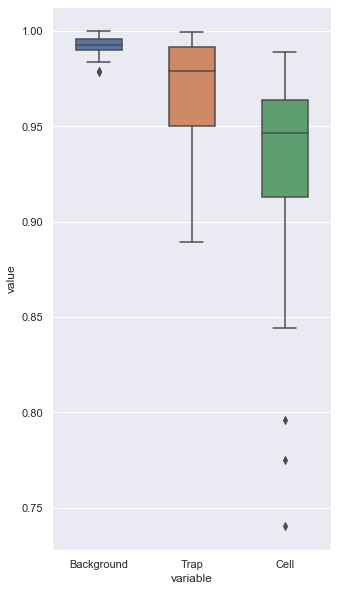

In [63]:
sns.set(rc={'figure.figsize':(5, 10)})
sns.boxplot(x="variable", y="value", data=pd.melt(recall_result), width = 0.5)

#plt.show()
plt.savefig('recall.png')